<a href="https://colab.research.google.com/github/GMoncrieff/mcmc_vs_advi/blob/master/pymc3_advi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
import theano
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

import theano.tensor as tt

import argparse
from google.colab import drive
from google.colab import auth
import seaborn as sns
import logging

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data prep

In [0]:
pen_dat = pd.read_csv('https://storage.googleapis.com/data-sharing-gmoncrieff/pyro_test.csv')
pen_dat.DA = pen_dat.DA/365.25
#pen_dat = pen_dat[pen_dat.nid<55]

df = pen_dat[["DA", "ND", "nid","tmax01", "tmin07"]]
dfg = df[['tmax01','tmin07','nid']].groupby('nid').first().sort_values(['nid'],ascending=True)
df['nid'] = df['nid']-1

n_site = len(df.nid.unique())
total_size = len(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
#plot levels conditions
envg1 = dfg.tmax01.values
envg2 = dfg.tmin07.values
nid = df.nid.values
ndvi = df.ND.values
age = df.DA.values

## inspect data
#### variables are  
DA -  age in years  
ND - ndvi  
nid - plot id  
tmax01 - max jan temp  
tmin07 - min july temp  

In [0]:
df

,DA,ND,nid,tmax01,tmin07
0,0.090349,0.2247,0,23.863451,8.382595
1,0.134155,0.2305,0,23.863451,8.382595
2,0.177960,0.0000,0,23.863451,8.382595
3,0.221766,0.2056,0,23.863451,8.382595
4,0.265572,0.1885,0,23.863451,8.382595
...,...,...,...,...,...
138833,15.531828,0.5663,418,25.354478,3.405932
138834,15.575633,0.5476,418,25.354478,3.405932
138835,15.619439,0.6273,418,25.354478,3.405932
138836,15.663244,0.5237,418,25.354478,3.405932


## MCMC with NUTS

In [0]:
with pm.Model():

  eps = pm.Uniform("sigma", lower=0, upper=100)
  a_sigma = pm.Uniform("a_sigma", lower=0, upper=100)
  g_sigma = pm.Uniform("g_sigma", lower=0, upper=100)
  l_sigma = pm.Uniform("l_sigma", lower=0, upper=100)

  gamma_b1 = pm.Normal("gamma_b1", mu=0., sigma=100**2)
  lamb_b1 = pm.Normal("lamb_b1", mu=0., sigma=100**2)
  gamma_b2 = pm.Normal("gamma_b2", mu=0., sigma=100**2)
  lamb_b2 = pm.Normal("lamb_b2", mu=0., sigma=100**2)

  alpha_mu = pm.Normal("alpha_mu", mu=0., sigma=100**2)
  
  gamma_mu = (envg1*gamma_b1) + (envg2*gamma_b2)
  lamb_mu = (envg1*lamb_b1) + (envg2*lamb_b2)
  
  alpha = pm.Lognormal("alpha", mu=alpha_mu, sigma=a_sigma,shape=n_site)
  gamma = pm.Lognormal("gamma", mu=gamma_mu, sigma=g_sigma,shape=n_site)
  lamb = pm.Lognormal("lamb", mu=lamb_mu, sigma=l_sigma,shape=n_site)

  ap = alpha[nid]
  gp = gamma[nid]
  lp = lamb[nid]
  theta = ap+gp-(gp*tt.exp((-1*(age/lp))))

  ndvi_like = pm.Normal('ndvi_like', mu=theta, sigma=eps, observed=ndvi, total_size=len(df))

  trace = pm.sample(500, tune=200, chains=1, target_accept=0.9,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lamb, gamma, alpha, alpha_mu, lamb_b2, gamma_b2, lamb_b1, gamma_b1, l_sigma, g_sigma, a_sigma, sigma]
100%|██████████| 700/700 [1:29:00<00:00,  7.63s/it]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [0]:
trace_save = pm.save_trace(trace,directory = '/content/drive/My Drive/colab_data/trace')

##Stochastic variational inference

essentially we feed the optimiser small random batches of data, and iterively update parameter estimates. 

In [0]:
nid_t = pm.Minibatch(nid, 10000)
ndvi_t = pm.Minibatch(ndvi, 10000)
age_t = pm.Minibatch(age, 10000)

/usr/local/lib/python3.6/dist-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [0]:
with pm.Model():

  eps = pm.Uniform("sigma", lower=0, upper=100)
  a_sigma = pm.Uniform("a_sigma", lower=0, upper=100)
  g_sigma = pm.Uniform("g_sigma", lower=0, upper=100)
  l_sigma = pm.Uniform("l_sigma", lower=0, upper=100)

  gamma_b1 = pm.Normal("gamma_b1", mu=0., sigma=100**2)
  lamb_b1 = pm.Normal("lamb_b1", mu=0., sigma=100**2)
  gamma_b2 = pm.Normal("gamma_b2", mu=0., sigma=100**2)
  lamb_b2 = pm.Normal("lamb_b2", mu=0., sigma=100**2)

  alpha_mu = pm.Normal("alpha_mu", mu=0., sigma=100**2)
  
  gamma_mu = (envg1*gamma_b1) + (envg2*gamma_b2)
  lamb_mu = (envg1*lamb_b1) + (envg2*lamb_b2)
  
  alpha = pm.Lognormal("alpha", mu=alpha_mu, sigma=a_sigma,shape=n_site)
  gamma = pm.Lognormal("gamma", mu=gamma_mu, sigma=g_sigma,shape=n_site)
  lamb = pm.Lognormal("lamb", mu=lamb_mu, sigma=l_sigma,shape=n_site)

  ap = alpha[nid_t]
  gp = gamma[nid_t]
  lp = lamb[nid_t]
  theta = ap+gp-(gp*tt.exp((-1*(age_t/lp))))

  ndvi_like = pm.Normal('ndvi_like', mu=theta, sigma=eps, observed=ndvi_t, total_size=len(df))
  #obj_optimizer=pm.adagrad(learning_rate=.01)
 #obj_optimizer=pm.adam(learning_rate=0.001),
    #obj_optimizer=pm.adadelta()
  approx = pm.fit(5000, method='advi',
                  obj_optimizer=pm.adam(learning_rate=0.005),
                  progressbar=True, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = -11,391: 100%|██████████| 5000/5000 [00:14<00:00, 354.37it/s]
Finished [100%]: Average Loss = -11,392


## RAAAD, it converges in 14 seconds. Commpare this to MCMC which takes hours. JAGS takes hours too.

view the loss through over iterations

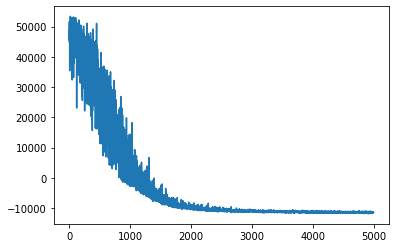

In [0]:
plt.plot(approx.hist);

## Check agreement in fitted global parameters

In [0]:
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

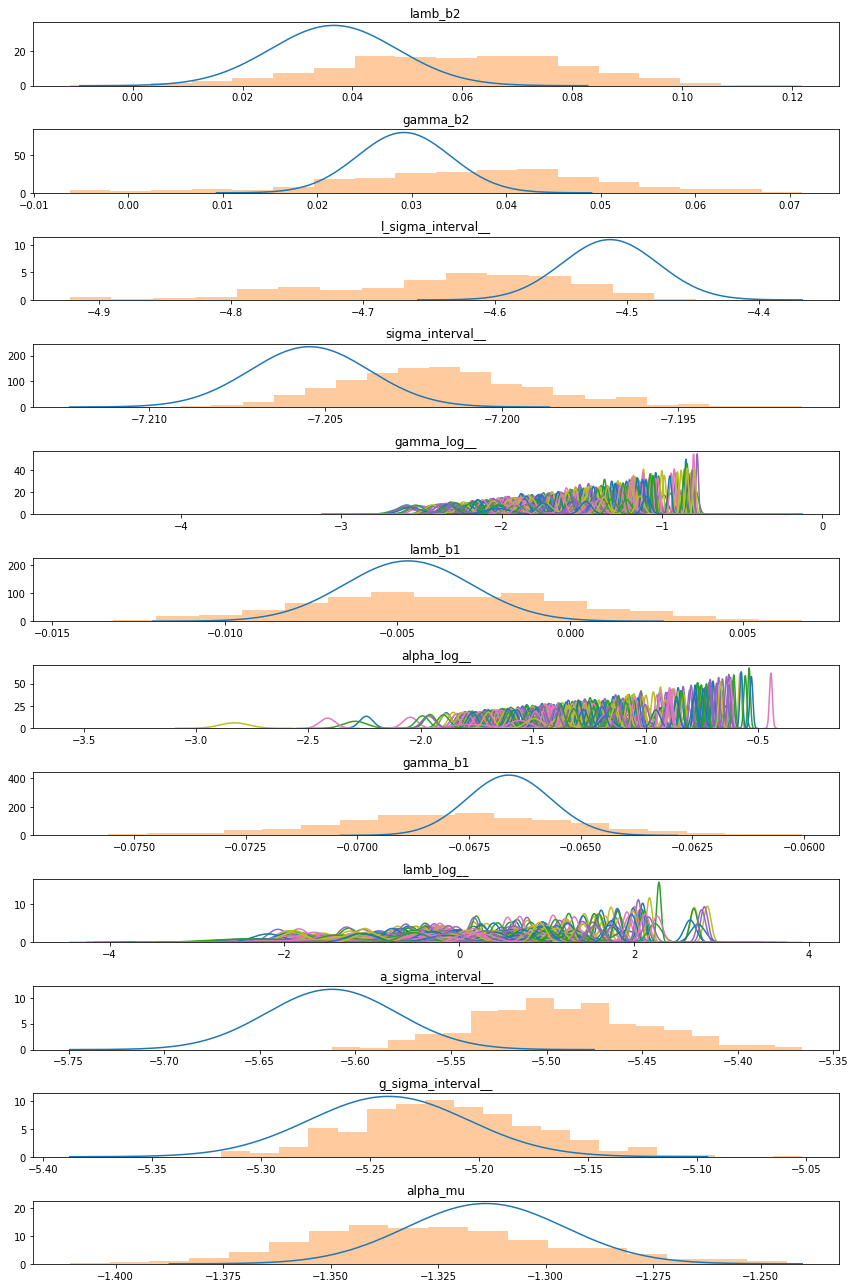

In [0]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if trace[var].ndim > 1:
            t = trace[var][i]
        else:
            t = trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()

## Check plot parameters agreement between methods

In [0]:
lmean_mcmc = trace['lamb_log__'].mean(axis=0)
lmean_svi = means['lamb_log__']
amean_mcmc = trace['alpha_log__'].mean(axis=0)
amean_svi = means['alpha_log__']
gmean_mcmc = trace['gamma_log__'].mean(axis=0)
gmean_svi = means['gamma_log__']

xlin = np.linspace(-3, 3, 100)
ylin = xlin

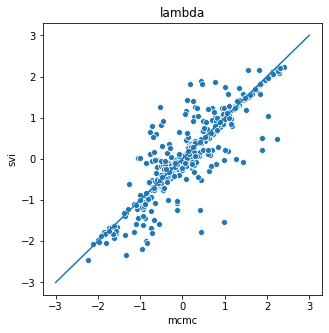

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set(xlabel='mcmc', ylabel='svi',title='lambda')
sns.scatterplot(lmean_mcmc,lmean_svi, ax=ax)
sns.lineplot(x=xlin, y=ylin, ax=ax)

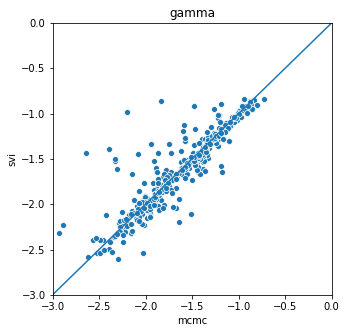

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([-3,0])
ax.set_ylim([-3,0])
ax.set(xlabel='mcmc', ylabel='svi',title='gamma')
sns.scatterplot(gmean_mcmc,gmean_svi, ax=ax)
sns.lineplot(x=xlin, y=ylin, ax=ax)

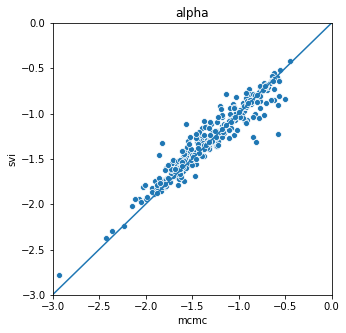

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([-3,0])
ax.set_ylim([-3,0])
ax.set(xlabel='mcmc', ylabel='svi',title='alpha')
sns.scatterplot(amean_mcmc,amean_svi, ax=ax)
sns.lineplot(x=xlin, y=ylin, ax=ax)